In [63]:
import pandas as pd
import numpy as np
import csv

geco_train_english = pd.read_csv('../data/geco/english/train.tsv', sep='\t', encoding='utf8', quoting=csv.QUOTE_NONE)
geco_test_english = pd.read_csv('../data/geco/english/test.tsv', sep='\t', encoding='utf8', quoting=csv.QUOTE_NONE)

geco_train_dutch = pd.read_csv('../data/geco/dutch/train.tsv', sep='\t', encoding='utf8')
geco_test_dutch = pd.read_csv('../data/geco/dutch/test.tsv', sep='\t', encoding='utf8')

geco_train_english = geco_train_english[['participant', 'text_id', 'sentence_id', 'text', 'token_count', 'fix_count', 'fix_prob', 'mean_fix_dur', 'first_fix_dur', 'first_pass_dur', 'tot_fix_dur', 'refix_count', 'reread_prob', 'tot_regr_from_dur']]
geco_test_english = geco_test_english[['participant', 'text_id', 'sentence_id', 'text', 'token_count', 'fix_count', 'fix_prob', 'mean_fix_dur', 'first_fix_dur', 'first_pass_dur', 'tot_fix_dur', 'refix_count', 'reread_prob', 'tot_regr_from_dur']]

In [64]:
# with open('data/geco/english/test.tsv',  'r', encoding='utf8') as infile:
#     with open('data/geco/english/test_sents.txt', 'w', encoding='utf8') as outfile:
#         lines = infile.readlines()
#         for i, line in enumerate(lines):
#             if i > 0:
#                 elements = line.strip('\n').split('\t')
#                 sent = elements[3]
#                 outfile.write(sent + '\n')

Concatenate the linguistic features associated with the GECO sentences in English and Dutch:

In [65]:
en_geco_train_feats = pd.read_csv('../data/geco/english/train_feats.csv', sep='\t')
en_geco_train_feats = en_geco_train_feats.drop('Filename', axis=1)
en_geco_train_feats.reset_index(drop=True)

en_train_cols =  geco_train_english.columns.to_list() + en_geco_train_feats.columns.to_list()
en_train_concatenation = np.concatenate([geco_train_english, en_geco_train_feats], axis=1)
en_geco_train_full = pd.DataFrame(en_train_concatenation, columns=en_train_cols)

In [66]:
en_geco_test_feats = pd.read_csv('../data/geco/english/test_feats.csv', sep='\t')
en_geco_test_feats = en_geco_test_feats.drop('Filename', axis=1)
en_geco_test_feats.reset_index(drop=True)

en_test_cols = geco_test_english.columns.to_list() + en_geco_test_feats.columns.to_list()
en_test_concatenation = np.concatenate([geco_test_english, en_geco_test_feats], axis=1)
en_geco_test_full = pd.DataFrame(en_test_concatenation, columns=en_test_cols)

In [67]:
dutch_geco_train_feats = pd.read_csv('../data/geco/dutch/train_feats.csv', sep='\t')
dutch_geco_train_feats = dutch_geco_train_feats.drop('Filename', axis=1)
dutch_geco_train_feats.reset_index(drop=True)

dutch_train_cols = geco_train_dutch.columns.to_list() + dutch_geco_train_feats.columns.to_list()
dutch_train_concatenation = np.concatenate([geco_train_dutch, dutch_geco_train_feats], axis=1)
dutch_geco_train_full = pd.DataFrame(dutch_train_concatenation, columns=dutch_train_cols)

In [68]:
dutch_geco_test_feats = pd.read_csv('../data/geco/dutch/test_feats.csv', sep='\t')
dutch_geco_test_feats = dutch_geco_test_feats.drop('Filename', axis=1)
dutch_geco_test_feats.reset_index(drop=True)

test_cols = geco_test_dutch.columns.to_list() + dutch_geco_test_feats.columns.to_list()
test_concatenation = np.concatenate([geco_test_dutch, dutch_geco_test_feats], axis=1)
dutch_geco_test_full = pd.DataFrame(test_concatenation, columns=test_cols)

Concatenate the train and test sets:

In [69]:
en_geco_train_full.reset_index(drop=True)
en_geco_test_full.reset_index(drop=True)
dutch_geco_train_full.reset_index(drop=True)
dutch_geco_test_full.reset_index(drop=True)

geco_english = pd.concat([en_geco_train_full, en_geco_test_full])
geco_dutch = pd.concat([dutch_geco_train_full, dutch_geco_test_full])

Add frequencies to dataframes:

In [70]:
from wordfreq import zipf_frequency
import numpy as np
import string

# Map to look up languages in the wordfreq package
language_map = {'Dutch': 'nl',
                'English': 'en',
                'Finnish': 'fi',
                'German': 'de',
                'Greek': 'el',
                'Hebrew': 'he',
                'Korean': 'ko',
                'Norwegian': 'nb',
                'Russian': 'ru',
                'Spanish': 'es',
                'Turkish': 'tr'}

def get_avg_token_freq(sentences, language):

    avg_token_freqs = []
    
    for sentence in sentences:
        
        # remove punctuation
        clean_sentence = sentence.translate(str.maketrans('', '', string.punctuation))

        # split sentence based on spaces
        tokens = clean_sentence.split(' ')
        
        # get zipf frequency of each token
        freqs = []
        for token in tokens:
            freq = zipf_frequency(token, language_map[language], wordlist='best', minimum=1.0)
            freqs.append(freq)
        
        # calculate average token frequency in the sentence
        avg_token_freqs.append(np.mean(freqs))

    return avg_token_freqs

def get_n_low_freq_words(sentences, language, threshold=4):

    num_low_freq_words_per_sent = []

    for sentence in sentences:
        
        num_low_freq_words = 0
        
        # remove punctuation
        clean_sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        
        # split sentence based on spaces
        tokens = clean_sentence.split(' ')
        
        # get zipf frequency of each token
        for token in tokens:
            freq = zipf_frequency(token, language_map[language], wordlist='best', minimum=1.0)

            # check if the frequency is below the treshold --> if so, count it as low-frequency
            if freq < threshold:
                num_low_freq_words += 1
            else:
                # if the word is not in the dictionary, continue
                continue
                
        num_low_freq_words_per_sent.append(num_low_freq_words)

    return num_low_freq_words_per_sent

def get_avg_word_length_with_punct(sentences):

    avg_word_lengths = []
    
    for sentence in sentences:
        
        # split sentence based on spaces
        words = sentence.split(' ')
        
        # get word lengths
        word_lengths = [len(word) for word in words]
        
        # calculate average word length in the sentence
        avg_word_lengths.append(np.mean(word_lengths))
        
    return avg_word_lengths

In [71]:
geco_english['avg_token_freq'] = get_avg_token_freq(geco_english['text'].tolist(), 'English')
geco_english['n_low_freq_words'] = get_n_low_freq_words(geco_english['text'].tolist(), 'English')
geco_english['avg_word_length'] = get_avg_word_length_with_punct(geco_english['text'].tolist())

geco_dutch['avg_token_freq'] = get_avg_token_freq(geco_dutch['text'].tolist(), 'Dutch')
geco_dutch['n_low_freq_words'] = get_n_low_freq_words(geco_dutch['text'].tolist(), 'Dutch')
geco_dutch['avg_word_length'] = get_avg_word_length_with_punct(geco_dutch['text'].tolist())

Scale eye-tracking features to fall in the range 0-100:

In [72]:
from sklearn.preprocessing import MinMaxScaler

def scale(feature_values):

    scaler = MinMaxScaler(feature_range=(0,100))

    # reshape 1D array to 2D
    reshaped_feature_list = np.array(feature_values).reshape(-1, 1)

    # scale feature values between 0 and 100
    scaled_feature_values = scaler.fit_transform(reshaped_feature_list)

    # flatten the 2D array to 1D
    flat_scaled_feature_values = np.ravel(scaled_feature_values)

    return flat_scaled_feature_values

def inverse_transform(true_values, predicted_values):
    
    scaler = MinMaxScaler(feature_range=(0,100))

    # reshape 1D array to 2D
    reshaped_feature_list = np.array(true_values).reshape(-1, 1)

    # scale feature values between 0 and 100
    scaled_feature_values = scaler.fit_transform(reshaped_feature_list)

    # flatten the 2D array to 1D
    flat_scaled_feature_values = np.ravel(scaled_feature_values)
    
    # inverse transform
    inversed_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1,1))
    
    # flatten the 2D array to 1D
    flat_inversed_values = np.ravel(inversed_values)
    
    return flat_inversed_values

def add_scaled_columns(df):
    
    df['scaled_fpd'] = scale(df['first_pass_dur'].tolist())
    df['scaled_fxc'] = scale(df['fix_count'].tolist())
    df['scaled_tfd'] = scale(df['tot_fix_dur'].tolist())
    df['scaled_rd'] = scale(df['tot_regr_from_dur'].tolist())
    
    return df

In [73]:
# add columns with predictions

def add_preds(df, language):

    fpd_preds=[]
    fxc_preds=[]
    tfd_preds=[]
    rd_preds=[]

    with open(f'../results/eye-movement-prediction/preds_eval-xlm-geco2meco-english2{language}-scaled.tsv', 'r') as infile:
        lines = infile.readlines()
        for line in lines:
            items = line.split('\t')
            task = items[0]
            pred = float(items[1].lstrip('[').rstrip(']'))
            label = items[2]
            if task == 'scaled_fpd':
                fpd_preds.append(pred)
            elif task == 'scaled_fxc':
                fxc_preds.append(pred)
            elif task == 'scaled_tfd':
                tfd_preds.append(pred)
            elif task == 'scaled_rd':
                rd_preds.append(pred)

    df['fpd_pred'] = inverse_transform(df['first_pass_dur'], fpd_preds)
    df['fxc_pred'] = inverse_transform(df['fix_count'], fxc_preds)
    df['tfd_pred'] = inverse_transform(df['tot_fix_dur'], tfd_preds)
    df['rd_pred'] = inverse_transform(df['tot_regr_from_dur'], rd_preds)
    
    return df

In [74]:
# en_geco_train_scaled = add_scaled_columns(en_geco_train_full)
# en_geco_test_scaled = add_scaled_columns(en_geco_test_full)

# dutch_geco_train_scaled = add_scaled_columns(dutch_geco_train_full)
# dutch_geco_test_scaled = add_scaled_columns(dutch_geco_test_full)

In [75]:
# en_geco_train_scaled.to_csv('data/geco/english/train_scaled_and_correct_feats.tsv', sep='\t', encoding='utf8',quoting=csv.QUOTE_NONE)
# en_geco_test_scaled.to_csv('data/geco/english/test_scaled_and_correct_feats.tsv', sep='\t', encoding='utf8',quoting=csv.QUOTE_NONE)

# dutch_geco_train_scaled.to_csv('data/geco/dutch/train_scaled_and_correct_feats.tsv', sep='\t', encoding='utf8',quoting=csv.QUOTE_NONE)
# dutch_geco_test_scaled.to_csv('data/geco/dutch/test_scaled_and_correct_feats.tsv', sep='\t', encoding='utf8',quoting=csv.QUOTE_NONE)

In [76]:
geco_dutch = add_scaled_columns(geco_dutch)
geco_english = add_scaled_columns(geco_english)

Combine the MECO languages into a single dataframe:

In [77]:
import os
import pandas as pd

def get_meco_df(language):
    
    path = f'../data/meco/files_per_language/{language}/test.tsv'
    
    if os.path.exists(path):
        df = pd.read_csv(f'../data/meco/files_per_language/{language}/test.tsv', sep='\t', encoding='utf8')
        df['dataset'] = len(df) * [f'{language}']
        
        #add frequency information
#         df['avg_token_freq'] = get_avg_token_freq(df['text'], language)
#         df['n_low_freq_words'] = get_n_low_freq_words(df['text'], language)
#         df['avg_word_length'] = get_avg_word_length_with_punct(df['text'].tolist())

        df = add_scaled_columns(df)
        df = df.rename(columns={'sent.nwords': 'token_count'})
        df = add_preds(df, language)
    
    return df

In [78]:
meco_english = get_meco_df('English')
meco_dutch = get_meco_df('Dutch')
meco_turkish = get_meco_df('Turkish')
meco_hebrew = get_meco_df('Hebrew')
meco_russian = get_meco_df('Russian')
meco_finnish = get_meco_df('Finnish')
meco_spanish = get_meco_df('Spanish')
meco_greek = get_meco_df('Greek')
meco_german = get_meco_df('German')
meco_norwegian = get_meco_df('Norwegian')
#meco_korean = get_meco_df('Korean')

Plot features:

In [79]:
# Group features into categories
raw = ['tokens_per_sent', 'char_per_tok']
syntactic = ['avg_max_depth', 'avg_links_len', 'verbal_head_per_sent', 'avg_verb_edges']
morph_syn = ['lexical_density']
freq = ['avg_token_freq', 'n_low_freq_words']

Text(0.5, 1.0, 'Total Fixation Duration')

<Figure size 432x288 with 0 Axes>

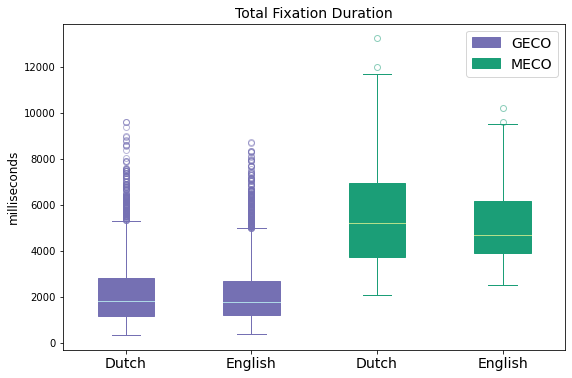

In [80]:
import matplotlib.pyplot as plt

fig = plt.figure()

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(9,6))

# rectangular box plot
bplot1 = ax1.boxplot([geco_dutch['tot_fix_dur'].tolist(), geco_english['tot_fix_dur'].tolist(), meco_dutch['tot_fix_dur'].tolist(), meco_english['tot_fix_dur'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['Dutch', 'English', 'Dutch', 'English'],
                     showfliers=True)  # will be used to label x-ticks

# fill with colors
colors = ['#7570b3', '#7570b3', '#1b9e77', '#1b9e77']
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    
for patch, color in zip(bplot1['fliers'], colors):
    patch.set_markeredgecolor(color)
    patch.set_alpha(0.5)
    
colors = ['lightblue', 'lightblue', '#b2df8a', '#b2df8a']
for patch, color in zip(bplot1['medians'], colors):
     patch.set_color(color)
        
colors = ['#7570b3', '#7570b3', '#7570b3', '#7570b3', '#1b9e77', '#1b9e77', '#1b9e77', '#1b9e77']
for patch, color in zip(bplot1['whiskers'], colors):
    patch.set_color(color)

for patch, color in zip(bplot1['caps'], colors):
    patch.set_color(color)
    
plt.ylabel("milliseconds", fontsize=12)
plt.xticks(fontsize=14)
plt.legend([bplot1["boxes"][0], bplot1["boxes"][2]], ['GECO', 'MECO'], loc='upper right', prop={'size': 14})
plt.title('Total Fixation Duration', fontsize=14)
        
#plt.savefig('plots/totfixdur-geco-meco.png', dpi=300, bbox_inches='tight', transparent=False)

<Figure size 432x288 with 0 Axes>

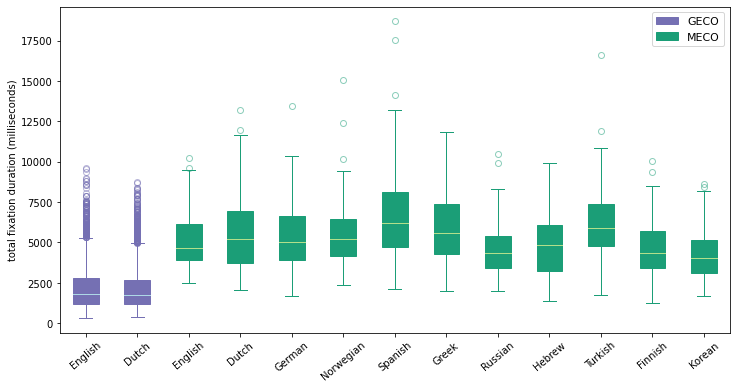

In [81]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

languages = ['English', 'Dutch', 'German', 'Norwegian', 'Spanish', 'Greek', 'Russian', 'Hebrew', 'Turkish', 'Finnish', 'Korean']

tfd_list = [geco_dutch['tot_fix_dur'].tolist(), geco_english['tot_fix_dur'].tolist()]
for lang in languages:
    df = get_meco_df(lang)
    tfd_list.append(df['tot_fix_dur'].tolist())
    
labels = ['English', 'Dutch', 'English', 'Dutch', 'German', 'Norwegian', 'Spanish', 'Greek', 'Russian', 'Hebrew', 'Turkish', 'Finnish', 'Korean']

# rectangular box plot
bplot1 = ax1.boxplot(tfd_list,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels,
                     showfliers=True)  # will be used to label x-ticks

# fill with colors
colors = ['#7570b3', '#7570b3'] + ['#1b9e77'] * len(languages) * 2
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    
for patch, color in zip(bplot1['fliers'], colors):
    patch.set_markeredgecolor(color)
    patch.set_alpha(0.5)
    
colors = ['lightblue', 'lightblue'] + ['#b2df8a'] * len(languages) * 2
for patch, color in zip(bplot1['medians'], colors):
     patch.set_color(color)
        
colors = ['#7570b3', '#7570b3', '#7570b3', '#7570b3'] + ['#1b9e77'] * len(languages) * 2
for patch, color in zip(bplot1['whiskers'], colors):
    patch.set_color(color)

for patch, color in zip(bplot1['caps'], colors):
    patch.set_color(color)
    
plt.xticks(rotation=40)
plt.ylabel("total fixation duration (milliseconds)")
plt.legend([bplot1["boxes"][0], bplot1["boxes"][2]], ['GECO', 'MECO'], loc='upper right', prop={'size': 11})
        
#plt.savefig('plots/tfd-distribution-all.pdf', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Total Fixation Duaration')

<Figure size 432x288 with 0 Axes>

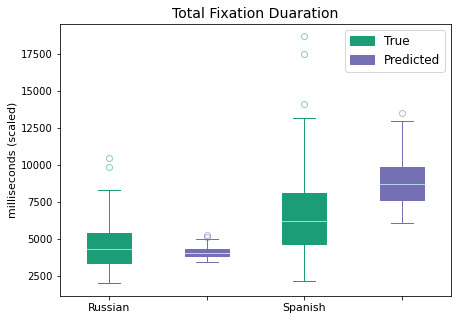

In [82]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

languages = ['Russian', 'Spanish']

tfd_list=[]
labels=[]
for language in languages:
    df = get_meco_df(language)
    tfd_list.append(df['tot_fix_dur'].tolist())
    tfd_list.append(df['tfd_pred'].tolist())
    labels.extend([language, ''])

# rectangular box plot
bplot1 = ax1.boxplot(tfd_list,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels,
                     showfliers=True)  # will be used to label x-ticks

# fill with colors
colors = ['#1b9e77', '#7570b3'] * len(languages)
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    
for patch, color in zip(bplot1['fliers'], colors):
    patch.set_markeredgecolor(color)
    patch.set_alpha(0.5)
    
colors = ['#b2df8a', 'lightblue'] * len(languages)
for patch, color in zip(bplot1['medians'], colors):
     patch.set_color(color)
        
colors = ['#1b9e77', '#1b9e77', '#7570b3', '#7570b3'] * len(languages)
for patch, color in zip(bplot1['whiskers'], colors):
    patch.set_color(color)

for patch, color in zip(bplot1['caps'], colors):
    patch.set_color(color)
    
plt.xticks(list(range(1, 5)), fontsize=11, horizontalalignment='center')
plt.ylabel("milliseconds (scaled)", fontsize=11)
plt.legend([bplot1["boxes"][0], bplot1["boxes"][1]], ['True', 'Predicted'], loc='upper right', prop={'size': 12})
plt.title('Total Fixation Duaration', fontsize=14)

#plt.savefig('plots/tfd-true-vs-pred.pdf', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

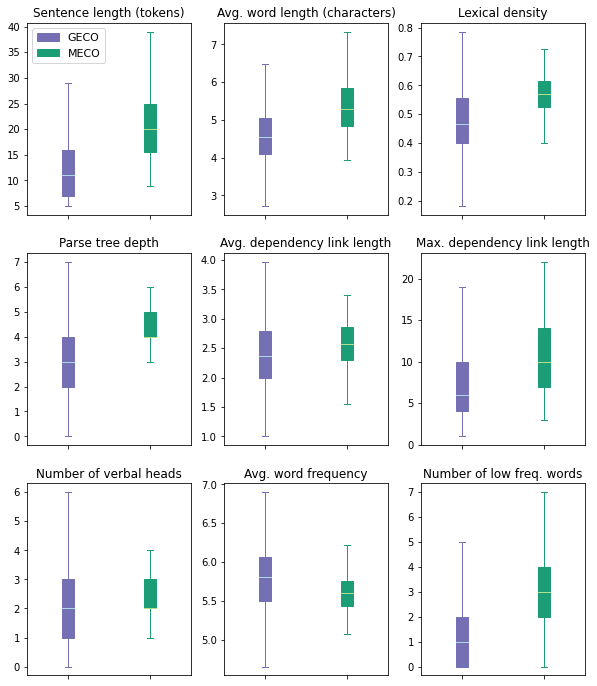

In [83]:
import matplotlib.pyplot as plt

fig = plt.figure()

fig, ((ax1, ax2, ax3), (ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(10,12))

dataset_1 = geco_english
dataset_2 = meco_english

# rectangular box plot
bplot1 = ax1.boxplot([dataset_1['token_count'].tolist(), dataset_2['token_count'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['',''],
                     showfliers=False)
ax1.set_title('Sentence length (tokens)')

bplot2 = ax2.boxplot([dataset_1['avg_word_length'].tolist(), dataset_2['avg_word_length'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['',''],
                     showfliers=False) 
ax2.set_title('Avg. word length (characters)')

bplot3 = ax3.boxplot([dataset_1['lexical_density'].tolist(), dataset_2['lexical_density'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['',''],
                     showfliers=False)  # will be used to label x-ticks
ax3.set_title('Lexical density')

bplot4 = ax4.boxplot([dataset_1['avg_max_depth'].tolist(), dataset_2['avg_max_depth'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['',''],
                     showfliers=False)  # will be used to label x-ticks
ax4.set_title('Parse tree depth')

bplot5 = ax5.boxplot([dataset_1['avg_links_len'].tolist(), dataset_2['avg_links_len'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['',''],
                     showfliers=False)  # will be used to label x-ticks
ax5.set_title('Avg. dependency link length')


bplot6 = ax6.boxplot([dataset_1['max_links_len'].tolist(), dataset_2['max_links_len'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['',''],
                     showfliers=False)  # will be used to label x-ticks
ax6.set_title('Max. dependency link length')

bplot7 = ax7.boxplot([dataset_1['verbal_head_per_sent'].tolist(), dataset_2['verbal_head_per_sent'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['',''],
                     showfliers=False)  # will be used to label x-ticks
ax7.set_title('Number of verbal heads')

bplot8 = ax8.boxplot([dataset_1['avg_token_freq'].tolist(), dataset_2['avg_token_freq'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['',''],
                     showfliers=False)  # will be used to label x-ticks
ax8.set_title('Avg. word frequency')

bplot9 = ax9.boxplot([dataset_1['n_low_freq_words'].tolist(), dataset_2['n_low_freq_words'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['',''],
                     showfliers=False)  # will be used to label x-ticks
ax9.set_title('Number of low freq. words')

# fill with colors
colors = ['#7570b3', '#1b9e77']
for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6, bplot7, bplot8, bplot9):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)

for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6, bplot7, bplot8, bplot9):
    for patch, color in zip(bplot['fliers'], colors):
        patch.set_markeredgecolor(color)
        patch.set_alpha(0.5)
        
colors = ['lightblue', '#b2df8a']
for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6, bplot7, bplot8, bplot9):
    for patch, color in zip(bplot['medians'], colors):
        patch.set_color(color)
        
colors = ['#7570b3', '#7570b3', '#1b9e77', '#1b9e77']
for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6, bplot7, bplot8, bplot9):
    for patch, color in zip(bplot['whiskers'], colors):
        patch.set_color(color)

for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6, bplot7, bplot8, bplot9):
    for patch, color in zip(bplot['caps'], colors):
        patch.set_color(color)
        
ax1.legend([bplot1["boxes"][0], bplot1["boxes"][1]], ['GECO', 'MECO'], loc='upper left', prop={'size': 11})
        
#plt.savefig('plots/ling-complexity-geco-meco.pdf', dpi=300, bbox_inches='tight')

In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [95]:
target_feats = ['scaled_fpd', 'scaled_fxc', 'scaled_tfd', 'scaled_rd',
                'fpd_pred', 'fxc_pred', 'tfd_pred', 'rd_pred',
                'token_count', 'avg_word_length',             
                'lexical_density',                                                  
                'avg_max_depth', 'avg_links_len', 'max_links_len', 'verbal_head_per_sent', 
                'avg_token_freq', 'n_low_freq_words']                                    

name_mapping = {'scaled_fpd': 'first-pass duration',
                'scaled_fxc': 'fixation count',
                'scaled_tfd': 'total fixation duration',
                'scaled_rd': 'regression duration',
                 'fpd_pred': 'first-pass duration (pred)',
                 'fxc_pred': 'fixation count (pred)',
                 'tfd_pred': 'total fixation duration (pred)',
                 'rd_pred': 'regression duration (pred)',
                'token_count': 'sentence length (tokens)',
                'avg_word_length': 'avg. word length (characters)',
                'lexical_density': 'lexical density',
                'avg_max_depth': 'parse tree depth',
                'avg_links_len': 'avg. dependency link length',
                'max_links_len': 'max. dependency link length',
                'verbal_head_per_sent': 'number of verbal heads',
                'avg_token_freq': 'avg. word frequency',
                'n_low_freq_words': 'number of low frequency words'}

for f in target_feats:
    meco_english = meco_english.rename(columns={f'{f}': name_mapping[f]})

In [86]:
target_feats = ['scaled_fpd', 'scaled_fxc', 'scaled_tfd', 'scaled_rd',
                'token_count', 'avg_word_length',             
                'lexical_density',                                                  
                'avg_max_depth', 'avg_links_len', 'max_links_len', 'verbal_head_per_sent', 
                'avg_token_freq', 'n_low_freq_words']                                    

name_mapping = {'scaled_fpd': 'first-pass duration',
                'scaled_fxc': 'fixation count',
                'scaled_tfd': 'total fixation duration',
                'scaled_rd': 'regression duration',
                'token_count': 'sentence length (tokens)',
                'avg_word_length': 'avg. word length (characters)',
                'lexical_density': 'lexical density',
                'avg_max_depth': 'parse tree depth',
                'avg_links_len': 'avg. dependency link length',
                'max_links_len': 'max. dependency link length',
                'verbal_head_per_sent': 'number of verbal heads',
                'avg_token_freq': 'avg. word frequency',
                'n_low_freq_words': 'number of low frequency words'}

for f in target_feats:
    geco_english[f] = pd.to_numeric(geco_english[f], downcast="float")
    geco_english = geco_english.rename(columns={f'{f}': name_mapping[f]})

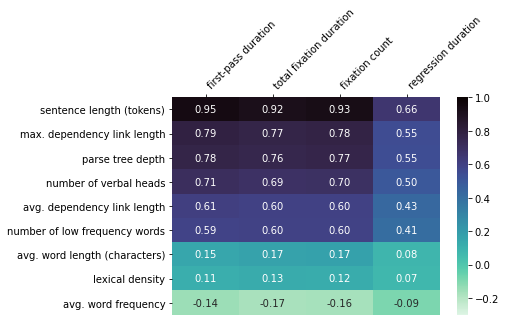

In [87]:
corr = geco_english[name_mapping.values()].corr(method='spearman')
corr = corr.drop(['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration'], axis=0)

heatmap = sns.heatmap(corr[['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration']].sort_values(by=['first-pass duration'],ascending=False),
            vmax=1,
            vmin=-0.3,
            cmap='mako_r',
            annot=True,
            linewidths=0,
            linecolor='white',
                     fmt='.2f')

x_axis_labels = ['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration']
heatmap.set_xticklabels(x_axis_labels, rotation=45, horizontalalignment='left')

heatmap.xaxis.tick_top() # x axis on top
heatmap.xaxis.set_label_position('top')

#plt.savefig('plots/geco-heatmap-train.pdf', dpi=300, bbox_inches='tight')

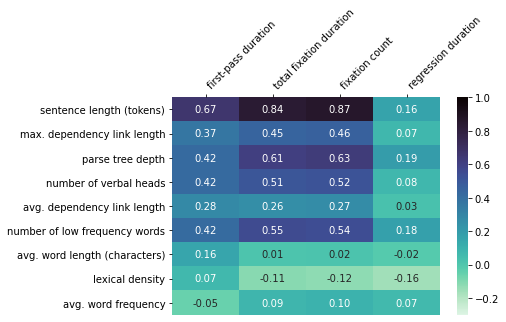

In [96]:
order = ['sentence length (tokens)',
         'max. dependency link length',
         'parse tree depth',
         'number of verbal heads',
         'avg. dependency link length',
         'number of low frequency words',
         'avg. word length (characters)',
         'lexical density',
         'avg. word frequency']

corr = meco_english[name_mapping.values()].corr(method='spearman')
corr = corr.drop(['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration',
                  'first-pass duration (pred)', 'total fixation duration (pred)', 'fixation count (pred)', 'regression duration (pred)'], 
                   axis=0)

corr = corr[['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration']]
corr = corr.reindex(order)

#plt.figure(figsize = (4.9,4))

heatmap = sns.heatmap(corr,
                      vmax=1,
                      vmin=-0.3,
                      cmap='mako_r',
                      annot=True,
                      linewidths=0,
                      linecolor='white',
                    # cbar=False,
                      fmt='.2f'
                     )

x_axis_labels = ['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration']

heatmap.set_xticklabels(x_axis_labels, rotation=45, horizontalalignment='left')

heatmap.xaxis.tick_top() # x axis on top
heatmap.xaxis.set_label_position('top')

#plt.savefig('plots/meco-heatmap-test.pdf', dpi=300, bbox_inches='tight', transparent=True)

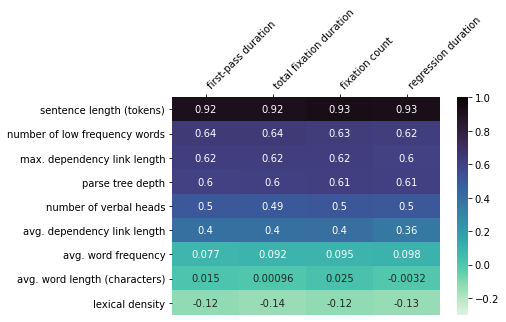

In [97]:
corr = meco_english[name_mapping.values()].corr(method='spearman')
corr = corr.drop(['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration',
                  'first-pass duration (pred)', 'total fixation duration (pred)', 'fixation count (pred)', 'regression duration (pred)'], 
                   axis=0)

heatmap = sns.heatmap(corr[['first-pass duration (pred)', 'total fixation duration (pred)', 'fixation count (pred)', 'regression duration (pred)']].sort_values(by=['first-pass duration (pred)'],ascending=False),
            vmax=1,
            vmin=-0.3,
            cmap='mako_r',
            annot=True,
            linewidths=0,
            linecolor='white',
            #yticklabels=False,
                     )

x_axis_labels = ['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration']

heatmap.set_xticklabels(x_axis_labels, rotation=45, horizontalalignment='left')

heatmap.xaxis.tick_top() # x axis on top
heatmap.xaxis.set_label_position('top')

#plt.savefig('plots/meco-english-predicted-heatmap.png', dpi=300, bbox_inches='tight', transparent=True)

In [92]:
# import scipy

In [93]:
# target_feats = ['first_pass_dur', 'fix_count', 'tot_fix_dur', 'tot_regr_from_dur',
#                 'token_count', 'avg_word_length',             
#                 'lexical_density',                                                  
#                 'avg_max_depth', 'avg_links_len', 'max_links_len', 'verbal_head_per_sent', 
#                 'avg_token_freq', 'n_low_freq_words'] 

# for et in target_feats[:4]:
#     print(et)
#     for ling in target_feats[4:]:
#         print("{:.8f}".format(scipy.stats.spearmanr(geco_english[et], geco_english[ling])[1]))

In [98]:
# from scipy.stats import spearmanr
# import pandas as pd
# import seaborn as sns

# def calculate_pvalues(df):
#     df = df.dropna()._get_numeric_data()
#     dfcols = pd.DataFrame(columns=df.columns)
#     pvalues = dfcols.transpose().join(dfcols, how='outer')
#     for r in df.columns:
#         for c in df.columns:
#             pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
#     return pvalues